<font size="10"> __Marketing campaigns analysis__ </font>

The goal of this project is to assess four marketing campaigns ran by a software development company in 2021, to understand:
1) What is working and what is not working
2) If the campaigns are reaching high quality leads to be ultimately converted to revenue. 

<font size="5"> **Setup** </font>

Importing the necessary libraries we will use for this project.

In [3]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import datetime
import numpy as np
import seaborn as sns
import re
from translate import Translator
import enchant
import joblib

<font size="5"> **Data preparation** </font>

The first step is uploading the data collected during each campaign, stored in a xlsx file. The first sheet contains basic info on the campaigns (name and page url namely); the second sheet contains info on page views, average visualization time and bounce rate; the third sheet contains info on the leads collected by each campaign (namely lead job title, industry, country, source and status).

In [4]:
#Loading the datasets

data_sheet1=pd.read_excel('Exercise data.xlsx', sheet_name='campaigns')
data_sheet2=pd.read_excel('Exercise data.xlsx', sheet_name='pages')
data_sheet3=pd.read_excel('Exercise data.xlsx', sheet_name='leads')

In [5]:
#Copying the datasets to later work with copies and not with the original data

data_campaigns=data_sheet1.copy()
data_pages=data_sheet2.copy()
data_leads=data_sheet3.copy()

The second step is data cleaning. We start with the data_pages dataset and do the following: 
1) Checking the rows containing missing values (and drop them, as it is a single row and not linked to any page url);
2) Converting the 'page_avg_time' column from 00:00:00 in total seconds.

In [6]:
data_pages['date']=pd.to_datetime(pd.Series(data_pages['date']).astype(str), format='%Y%m%d.0')

#Checking for missing values
null_data_pages=data_pages[data_pages.isnull().any(axis=1)]

#Checking for NaN
nan_data_pages=data_pages[data_pages.isna().any(axis=1)]

#Dropping the row containing missing values
data_pages=data_pages.dropna()

#Converting page_avg_time from 00:00:00 in total seconds
def get_sec(time_obj):
    return time_obj.hour*3600+time_obj.minute*60+time_obj.second

data_pages['page_avg_time_seconds']=data_pages['page_avg_time'].apply(get_sec)

data_pages

,Unnamed: 0,page_url,date,page_views,page_avg_time,page_bounce_rate,page_avg_time_seconds
0,0,url_3,2021-12-16,3853,00:01:00,0.8698,60
1,1,url_3,2021-12-14,3179,00:00:55,0.8665,55
2,2,url_3,2021-12-07,2843,00:01:05,0.8757,65
3,3,url_3,2021-12-12,2777,00:01:04,0.8788,64
4,4,url_3,2021-12-17,2570,00:00:56,0.8642,56
...,...,...,...,...,...,...,...
785,785,url_2,2021-11-29,1,00:00:00,1.0000,0
786,786,url_2,2021-12-03,1,00:00:33,0.0000,33
787,787,url_2,2021-12-09,1,00:01:32,0.0000,92
788,788,url_2,2021-12-12,1,00:01:01,0.0000,61


We continue cleaning the data_leads dataset. Just by having a quick look at it, it is immediately noticeable that some columns (specifically 'lead_job_title', 'lead_industry', 'lead_country' and 'lead_source') contain missing values. We count them for each column.

In [7]:
columns=data_leads.columns.tolist()
count_missing=[data_leads[column].isnull().sum() for column in columns]

count_missing

[0, 0, 0, 33, 2146, 263, 0, 640, 0]

We continue cleaning the data_leads dataset by dropping all rows containing numbers, punctuation and gibberish from columns supposed to contain text, and converting Chinese characters in English. 

In [8]:
#Remove specified columns with NaN values
data_jobs=data_leads.drop(['campaign_joined_date', 'lead_industry', 'lead_country', 'lead_source'], axis=1).dropna()

#Initialize English dictionary
d=enchant.Dict('en_US')

#Iterate over each index and job title
for ind, string in data_jobs['lead_job_title'].items():
    if re.search(r'[\u4e00-\u9fff]+', string):  #Check for Chinese characters
        translation=Translator(from_lang='chinese', to_lang='english')
        try:
            translated_word=translation.translate(string)
            data_jobs.at[ind, 'lead_job_title']=translated_word
        except:
            data_jobs.drop(index=ind, inplace=True)
    elif not re.search('[a-zA-Z]', string):  #Check if no English characters
        data_jobs.drop(index=ind, inplace=True)
    elif len(string.split())<2 and not d.check(string):  #Check if single-word not in English
        data_jobs.drop(index=ind, inplace=True)
data_jobs

,Unnamed: 0,lead_hashed_id,lead_job_title,campaign_name,lead_status
0,0,011c1b8f66f416ed05e466117839bc82,Student,Campaign 1,Disqualified
1,1,0214109a8d2ea5665e250426e666d745,SE,Campaign 1,Disqualified
2,2,02b78453c1a350f85dce07e6d1d135b5,engineer,Campaign 1,Nurture
3,3,03f08c9e402a968fbad2ef8b6df881b3,Professor,Campaign 1,Disqualified
4,4,04e1a8cbf3cf2f13a1d2ae1177dd5b45,Student,Campaign 1,Disqualified
...,...,...,...,...,...
2533,2533,fe435f6c04ab42f5e9da426aed4ef569,teacher,Campaign 4,Nurture
2535,2535,fe9c77091486712153c19828ab6aa3fb,Student,Campaign 4,Unsubscribed
2537,2537,ff4963dd5a0ffd94c8579633a9ca232a,swiftest,Campaign 4,New
2538,2538,ffe673add1ec24bc1e25e928eb36df03,Legend,Campaign 4,Nurture


<font size="5"> **Feature Engineering** </font>

The 'lead_industry' column is composed of 85% missing values, so it would have not been possible to use it for grouping the job titles by job area.
For this reason, two classifiers were selected: Stochastic Gradient Descent (SGD) and Multi-Layer Perceptron (MLP). A dataset listing job titles across multiple professional domains was used to train both classifiers, and the one with the higher accuracy was selected. For this specific use case, it was the SGD.

The necessary libraries to implement the machine learning algorithm are imported.

In [9]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
import pickle
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

In [10]:
jobs=pd.read_excel('Jobs.xlsx')  #Importing the Excel file containing job titles and corresponding job areas used to train the classifiers

jobs['y']=np.zeros(len(jobs['Job title']))
jobs['Area']=jobs['Area'].apply(lambda x: x.strip())

areas=jobs['Area'].unique()

for ind in jobs['Area'].index:
    job=jobs['Area'][ind]
    jobs.loc[ind, 'y']+=np.where(areas == job)[0][0]
    
X_train, X_test, Y_train, Y_test = train_test_split(jobs['Job title'], jobs['y'])

#Define a pipeline for SGDClassifier
sgd_pipeline=Pipeline([
    ('vectorizer',CountVectorizer()),
    ('classifier',SGDClassifier(loss='hinge')),
])

#Define a parameter grid for SGDClassifier
sgd_param_grid={
    'vectorizer__ngram_range':[(1, 1), (1, 2)],  # Uni-gram and bi-gram
    'classifier__alpha':[0.0001, 0.001, 0.01, 0.1, 1],
    'classifier__penalty':['l2', 'l1', 'elasticnet'],
}

#Define a pipeline for MLPClassifier
mlp_pipeline=Pipeline([
    ('vectorizer',CountVectorizer()),
    ('scaler',StandardScaler(with_mean=False)),
    ('classifier',MLPClassifier(max_iter=1000)),
])

#Define a parameter grid for MLPClassifier
mlp_param_grid={
    'vectorizer__ngram_range':[(1, 1), (1, 2)],  # Uni-gram and bi-gram
    'scaler__with_mean':[False],
    'classifier__hidden_layer_sizes':[(100,), (50, 50), (50, 100, 50)],
    'classifier__alpha':[0.0001, 0.001, 0.01],
}

#Perform grid search for SGDClassifier
sgd_grid_search=GridSearchCV(sgd_pipeline, sgd_param_grid, cv=5, verbose=1)
sgd_grid_search.fit(X_train, Y_train)

#Perform grid search for MLPClassifier
mlp_grid_search=GridSearchCV(mlp_pipeline, mlp_param_grid, cv=5, verbose=1)
mlp_grid_search.fit(X_train, Y_train)

#Get the best models
best_sgd_model=sgd_grid_search.best_estimator_
best_mlp_model=mlp_grid_search.best_estimator_

#Predict the test set labels
sgd_y_pred=best_sgd_model.predict(X_test)
mlp_y_pred=best_mlp_model.predict(X_test)

#Calculate accuracy
sgd_accuracy=accuracy_score(Y_test, sgd_y_pred)
mlp_accuracy=accuracy_score(Y_test, mlp_y_pred)

print("SGD Best Model:", sgd_grid_search.best_params_)
print("SGD Accuracy:", sgd_accuracy)
print("MLP Best Model:", mlp_grid_search.best_params_)
print("MLP Accuracy:", mlp_accuracy)

with open('sgd_best.pkl','wb') as f:
    pickle.dump(best_sgd_model,f)

with open('mlp_best.pkl','wb') as f:
    pickle.dump(best_mlp_model,f)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 18 candidates, totalling 90 fits
SGD Best Model: {'classifier__alpha': 0.001, 'classifier__penalty': 'l2', 'vectorizer__ngram_range': (1, 1)}
SGD Accuracy: 0.8554216867469879
MLP Best Model: {'classifier__alpha': 0.001, 'classifier__hidden_layer_sizes': (50, 50), 'scaler__with_mean': False, 'vectorizer__ngram_range': (1, 1)}
MLP Accuracy: 0.6144578313253012


Now that the data cleaning and feature engineering (namely the implementation of the SGD classifier) steps are completed, we can proceed with the data analytics and visualization steps simultaneously.

<font size="5"> **Data Analysis and visualization** </font>

We start by computing the 'score card' of each campaign, which lists the campaign's average visualization time, page views, bounce rate and total leads collected. These values are later saved in an Excel file.

In [11]:
#Merge data_campaigns and data_pages on 'page_url'
data_pages_merge=pd.merge(data_campaigns, data_pages, on='page_url')
campaign_names=data_pages_merge['campaign_name'].unique()

campaigns_dict={}

for campaign_name in campaign_names:
    data_pages_merge_campaign=data_pages_merge[data_pages_merge['campaign_name']==campaign_name]
    campaigns_dict[campaign_name]=data_pages_merge_campaign

#Group by 'campaign_name' and aggregate statistics
campaigns_cards_data=data_pages_merge.groupby('campaign_name').agg({
    'page_avg_time_seconds': 'mean',
    'page_views': 'sum',
    'page_bounce_rate': 'mean'
}).reset_index()

#Export DataFrame to Excel
campaigns_cards_data.to_excel('scorecards.xlsx', index=False)

campaigns_cards_data

,campaign_name,page_avg_time_seconds,page_views,page_bounce_rate
0,Campaign 1,68.165584,2048,0.512191
1,Campaign 2,112.437288,1610,0.593279
2,Campaign 3,73.875000,37122,0.789655
3,Campaign 4,87.571429,9630,0.491429


We proceed by computing some trends for each campaign, starting with the average visualization time and bounce rate per week.

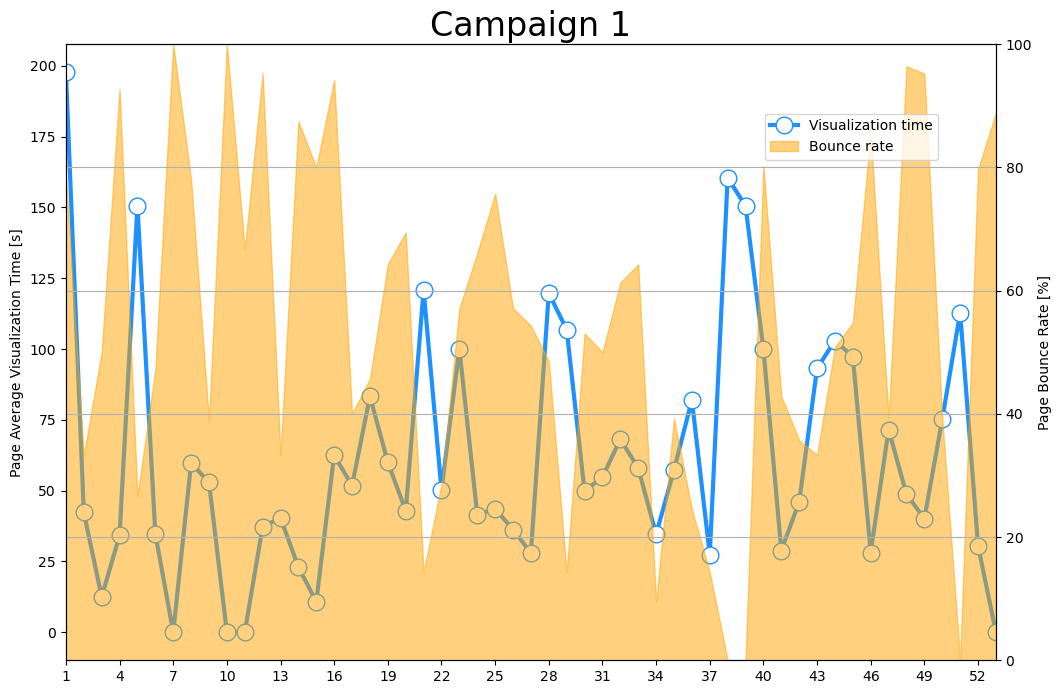

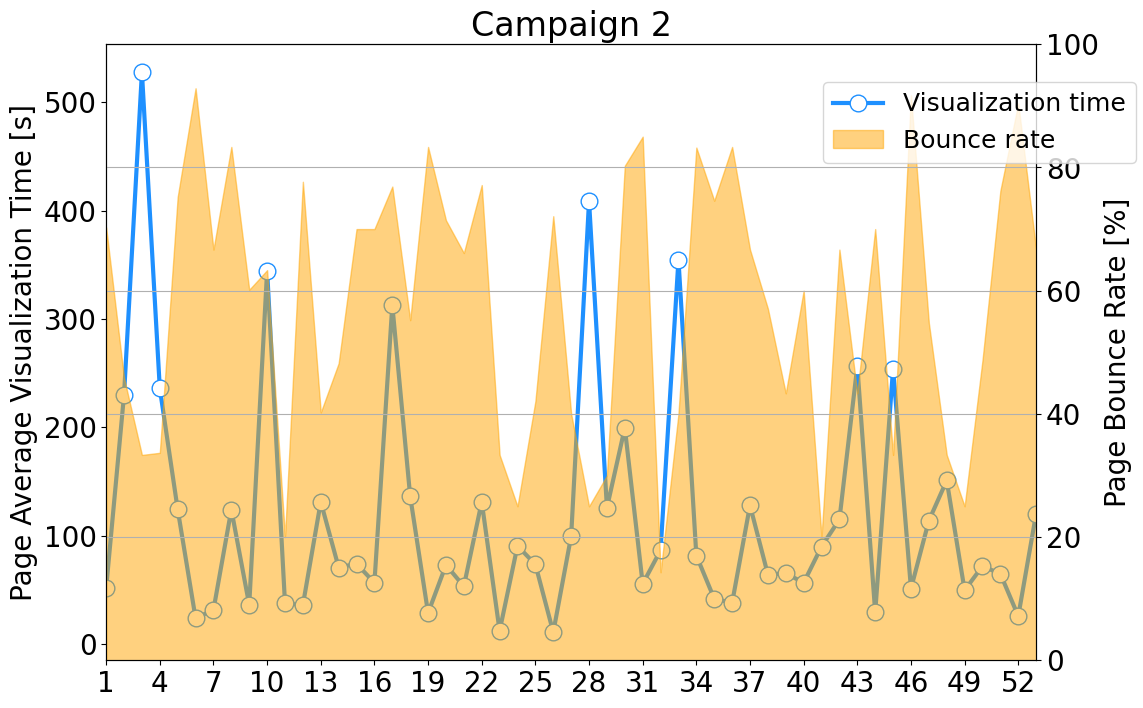

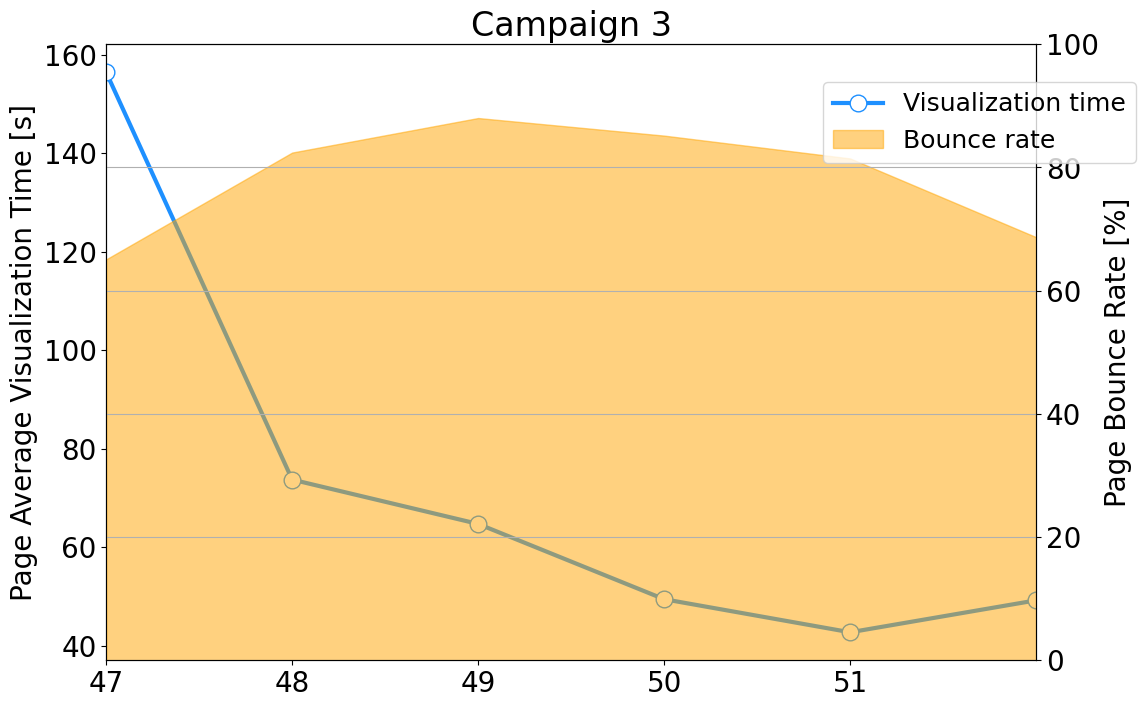

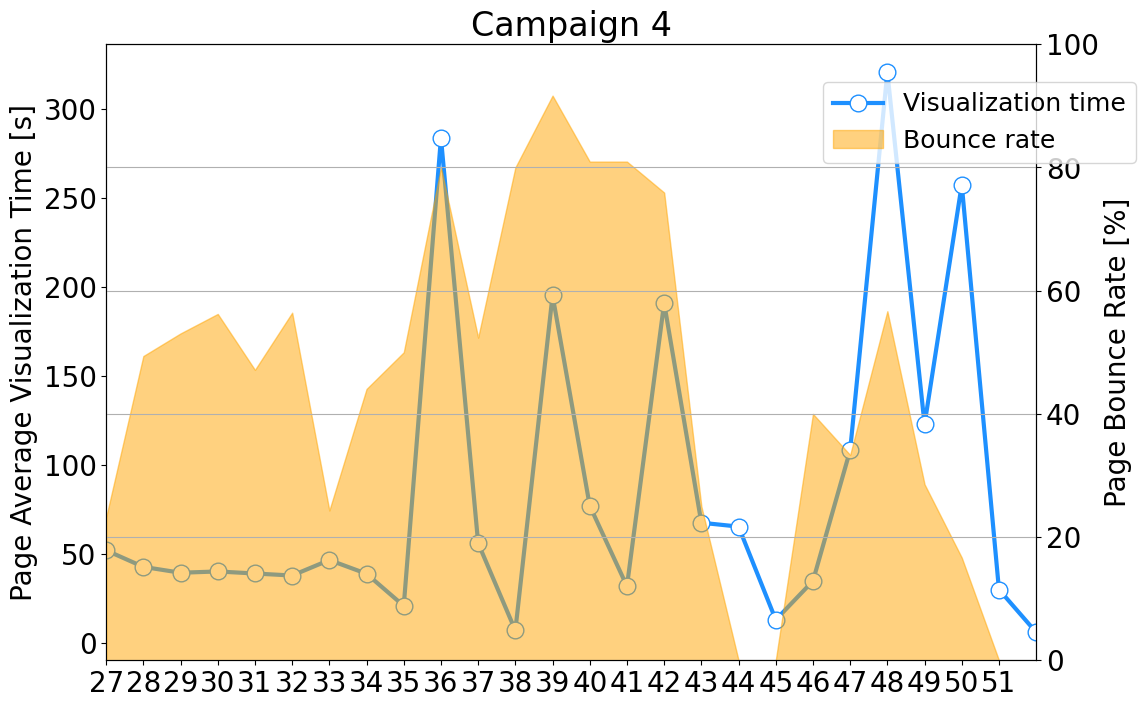

In [12]:
def plot_campaign_trends(df_sorted,title):
    fig,ax1=plt.subplots(figsize=(12, 8))  
    ax2=ax1.twinx()

    ax1.plot(np.unique(df_sorted['week']), df_sorted.groupby('week').mean()['page_avg_time_seconds'].values, color='dodgerblue', linewidth=3, marker='.', markersize=24, markerfacecolor='white', label='Visualization time')

    ax2.set_xlabel('Weeks')

    ax1.set_ylabel('Page Average Visualization Time [s]', color='black')
    ax1.tick_params('y', colors='black')

    ax2.set_ylabel('Page Bounce Rate [%]', color='black')
    ax2.tick_params('y', colors='black')
    ax2.set_ylim(0, 100)
    a=df_sorted.groupby('week').mean()['page_bounce_rate'].values*100
    ax2.fill_between(np.unique(df_sorted['week']).astype('int'), 0, a, color='orange', alpha=0.50, label='Bounce rate')

    fig.legend(loc=(0.72, 0.77))

    if (max(df_sorted['week'])-min(df_sorted['week']))>30:
        step=3
    else:
        step=1

    plt.xlim(min(df_sorted['week']), max(df_sorted['week']))
    plt.xticks(np.arange(min(df_sorted['week']), max(df_sorted['week']), step=step))
    plt.grid(True)

    plt.rc('font', size=20)
    plt.rc('axes', labelsize=20)
    plt.rc('xtick', labelsize=20)
    plt.rc('ytick', labelsize=20)
    plt.rc('legend', fontsize=18)
    plt.rc('figure', titlesize=20)
    plt.title(title)
    plt.show()

# Iterate over campaigns_dict and plot trends
for campaign_name, df in campaigns_dict.items():
    df_sorted=df.sort_values(by='date')
    df_sorted['week']=df_sorted['date'].dt.isocalendar()['week']
    df_sorted=df_sorted.drop(['date', 'page_avg_time', 'campaign_name', 'page_url'], axis=1)
    plot_campaign_trends(df_sorted,campaign_name)

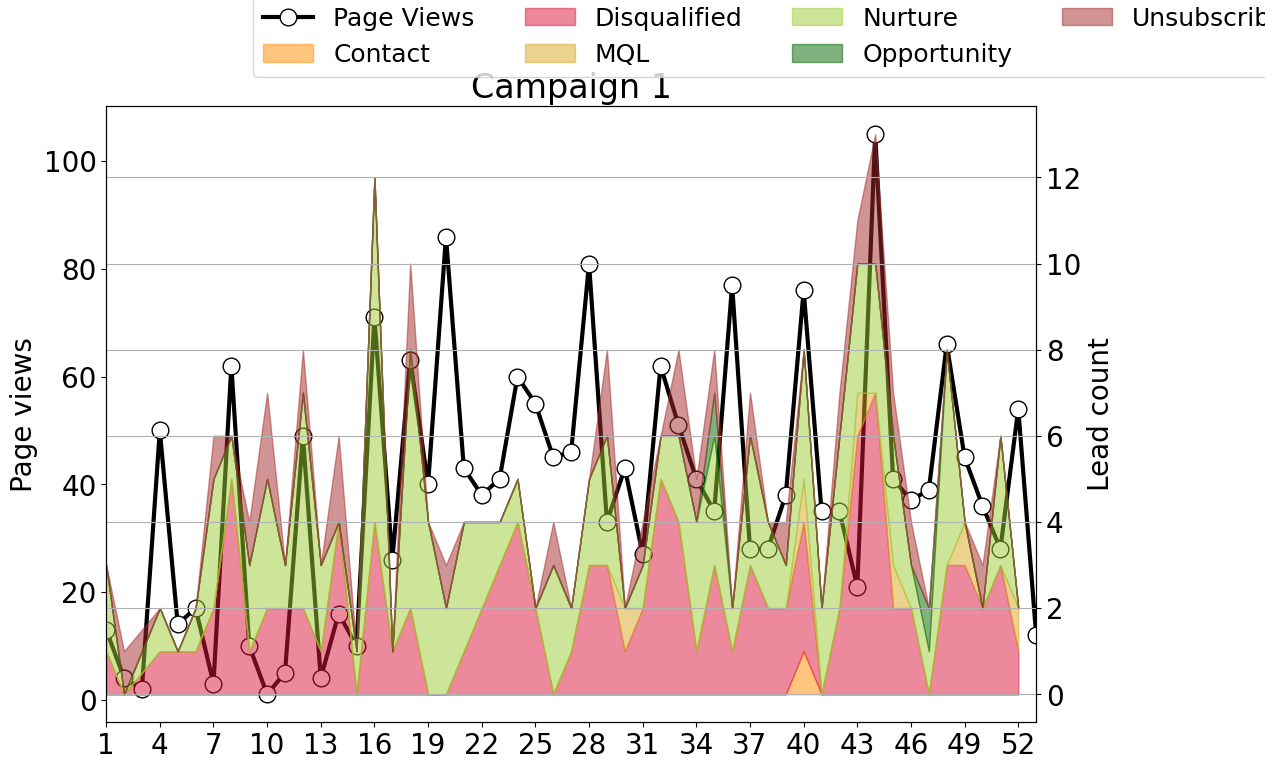

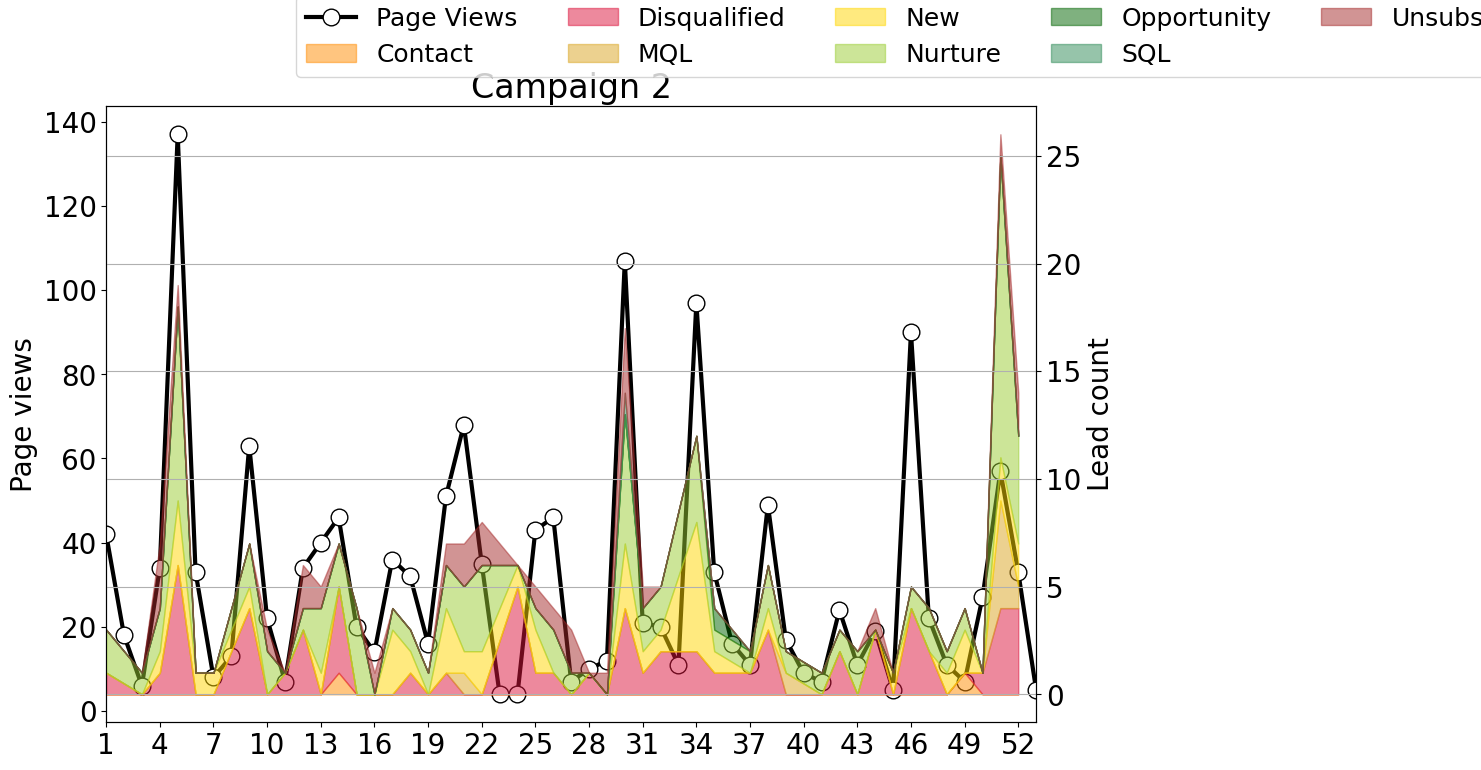

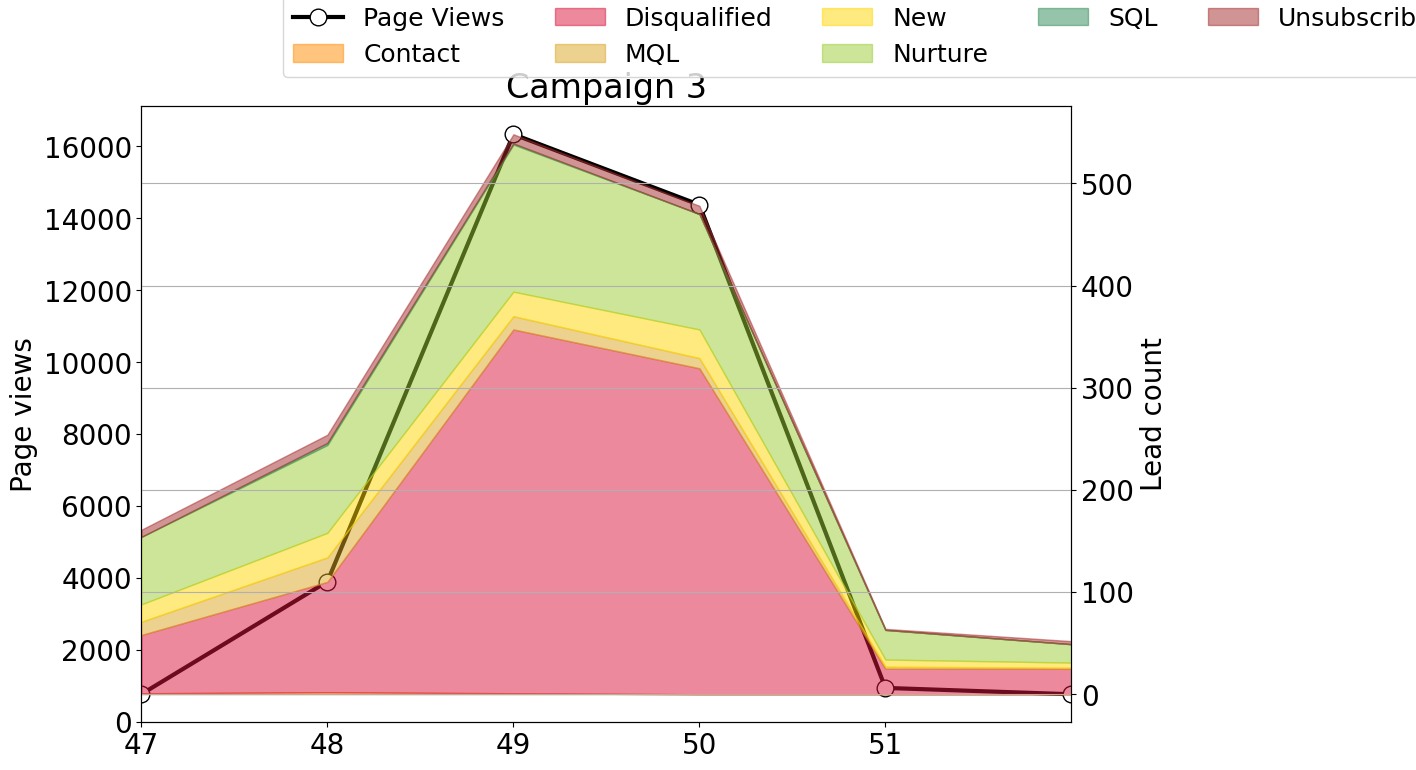

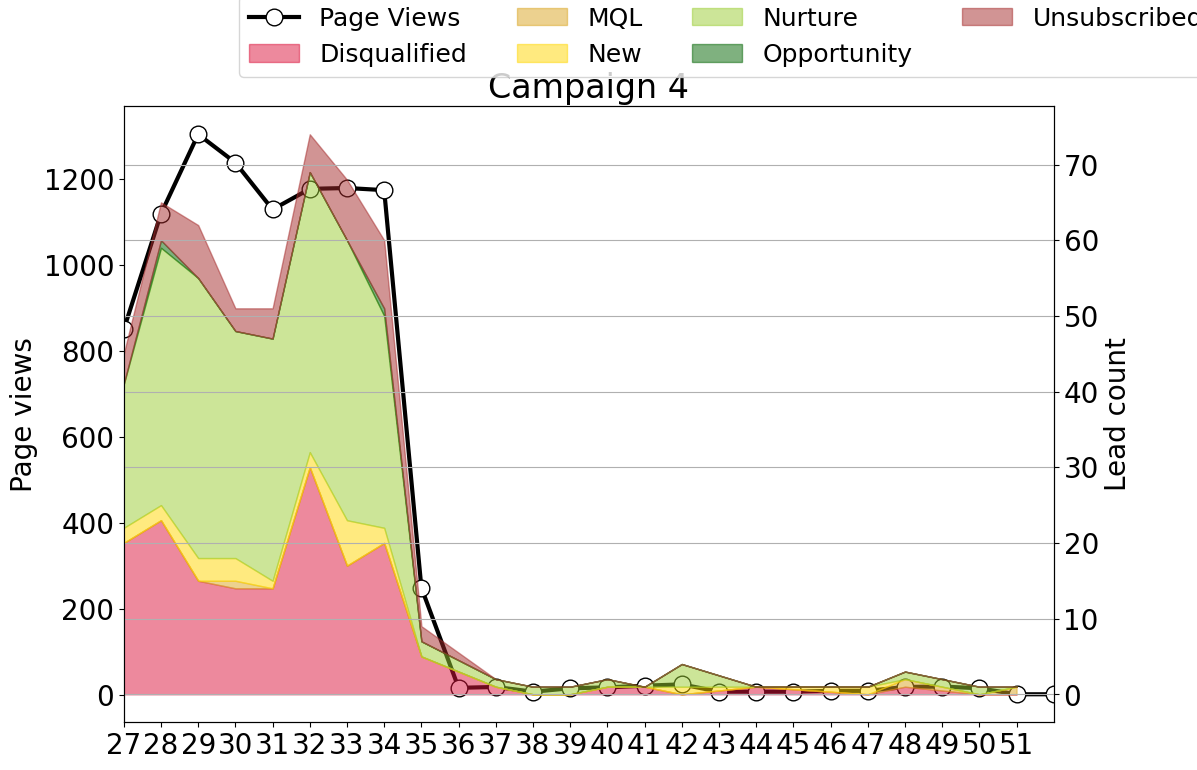

In [14]:
colors_dict={'Contact':'darkorange','Disqualified':'crimson','Unsubscribed':'brown','Nurture':'yellowgreen','MQL':'goldenrod','New':'gold','Opportunity':'darkgreen','SQL':'seagreen'}

def plot_campaign_leads_trends(df_sorted, pivot_leads, campaign_name):
    fig,ax1=plt.subplots(figsize=(12,8))
    ax2=ax1.twinx()

    ax1.plot(np.unique(df_sorted['week']), df_sorted.groupby('week').sum()['page_views'].values, color='black', label='Page Views', linewidth=3, marker='.', markersize=24, markerfacecolor='white')

    low_value=np.zeros(len(pivot_leads.index))
    for col in pivot_leads.columns:
        ax2.fill_between(np.unique(pivot_leads.index).astype('int'), low_value, low_value + pivot_leads[col], color=colors_dict[col], alpha=0.50, label=col)
        low_value+=pivot_leads[col]

    ax2.set_xlabel('Weeks')
    ax1.set_ylabel('Page views')
    ax2.set_ylabel('Lead count')

    if (max(df_sorted['week'])-min(df_sorted['week']))>30:
        step=3
    else:
        step=1

    plt.xlim(min(df_sorted['week']), max(df_sorted['week']))
    plt.xticks(np.arange(min(df_sorted['week']), max(df_sorted['week']), step=step))
    plt.grid(True)

    plt.rc('font', size=20)
    plt.rc('axes', labelsize=20)
    plt.rc('xtick', labelsize=20)
    plt.rc('ytick', labelsize=20)
    plt.rc('legend', fontsize=18)
    plt.rc('figure', titlesize=20)

    fig.legend(loc=(0.2,0.9), ncol=int(len(pivot_leads.columns)+1)/2+1)
    plt.title(campaign_name)
    plt.show()

# Iterate over campaigns_dict and plot trends
for campaign_name, df in campaigns_dict.items():
    df_sorted=df.sort_values(by='date')
    df_sorted['week']=df_sorted['date'].dt.isocalendar()['week']
    df_sorted=df_sorted.drop(['date', 'page_avg_time', 'campaign_name', 'page_url'], axis=1)

    #Create a copy of data_leads to avoid SettingWithCopyWarning
    data_leads_campaign=data_leads[data_leads['campaign_name']==campaign_name].copy()
    data_leads_campaign['week']=data_leads_campaign['campaign_joined_date'].dt.isocalendar()['week']

    data_leads_clean=data_leads_campaign[['week', 'lead_status', 'lead_hashed_id']].copy()
    leads_grouped=data_leads_clean.groupby(by=['week', 'lead_status']).count().reset_index()
    pivot_leads=leads_grouped.pivot(index='week', columns='lead_status', values='lead_hashed_id')
    pivot_leads=pivot_leads.fillna(0)

    plot_campaign_leads_trends(df_sorted, pivot_leads, campaign_name)


We now continue the analysis on the leads by looking at the leads status breakdown of each campaign.

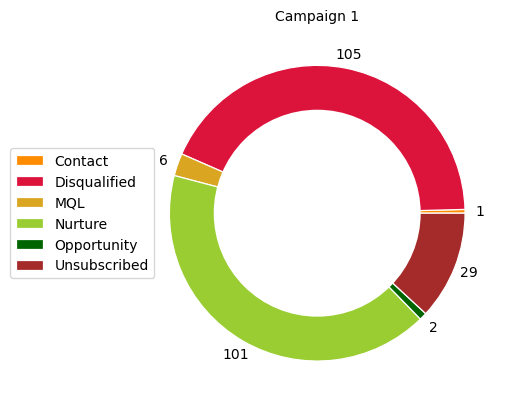

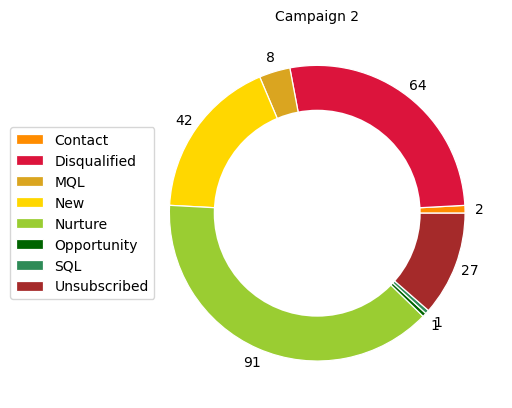

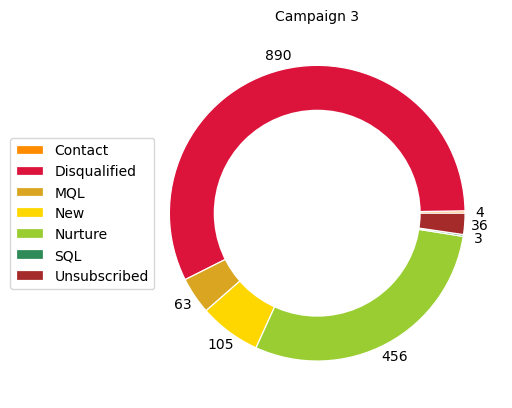

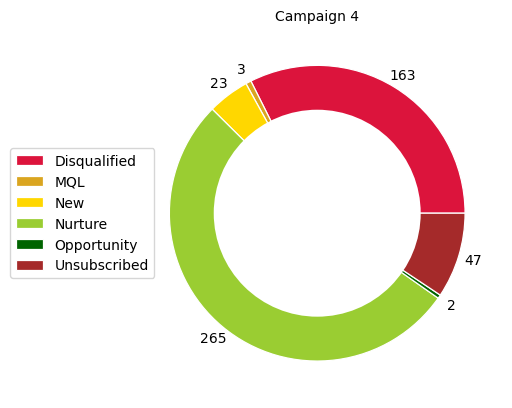

In [15]:
data_leads_filtered=data_leads.drop(['lead_job_title','lead_industry','lead_country','campaign_joined_date'], axis=1)

colors=['darkorange','red','lawngreen','lightseagreen','deepskyblue','cornflowerblue','mediumorchid','violet']

colors_dict={'Contact':'darkorange','Disqualified':'crimson','Unsubscribed':'brown','Nurture':'yellowgreen','MQL':'goldenrod','New':'gold','Opportunity':'darkgreen','SQL':'seagreen'}

#Set the fontsize for autopct
autopct_fontsize=10

for campaign in campaign_names:
    fig,ax=plt.subplots()
    leads_classify_status=data_leads_filtered[data_leads_filtered['campaign_name']==campaign].groupby('lead_status').count()
        
    data=leads_classify_status['campaign_name']
    colors=[colors_dict[k] for k in data.index] 

    explode=((0.00),)*len(colors)
    wp={'linewidth': 0.9, 'edgecolor':'white'}
    
    #Use textprops to set autopct fontsize
    ax.pie(data, labels=data.index, wedgeprops=wp, autopct=lambda x: '{:.0f}'.format(x*leads_classify_status['campaign_name'].sum()/100),
           explode=explode, colors=colors, labeldistance=None, pctdistance=1.1, textprops={'fontsize': autopct_fontsize})
    
    #Inner circle
    centre_circle=plt.Circle((0,0),0.70,fc='white')
    fig.gca().add_artist(centre_circle)

    plt.legend(bbox_to_anchor=(-0.35, 0.5), loc='center left', fontsize=10)
    
    SMALL_SIZE=10
    MEDIUM_SIZE=20
    BIGGER_SIZE=20
    
    plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=10)            # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
    plt.title(campaign)
    plt.show()


We proceed with the grouped bar chart showcasing the lead status breakdown per source.

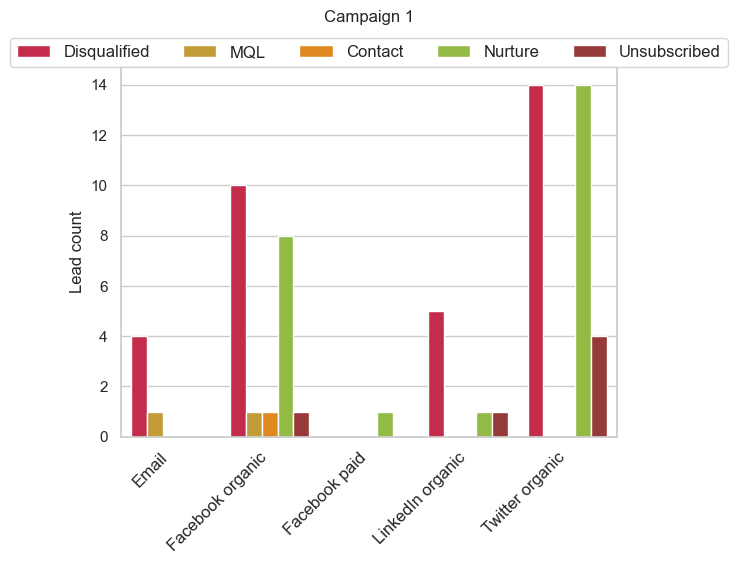

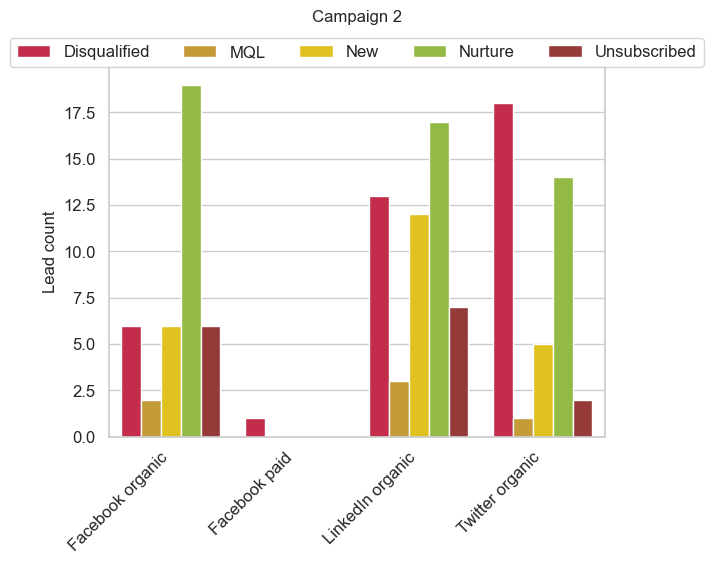

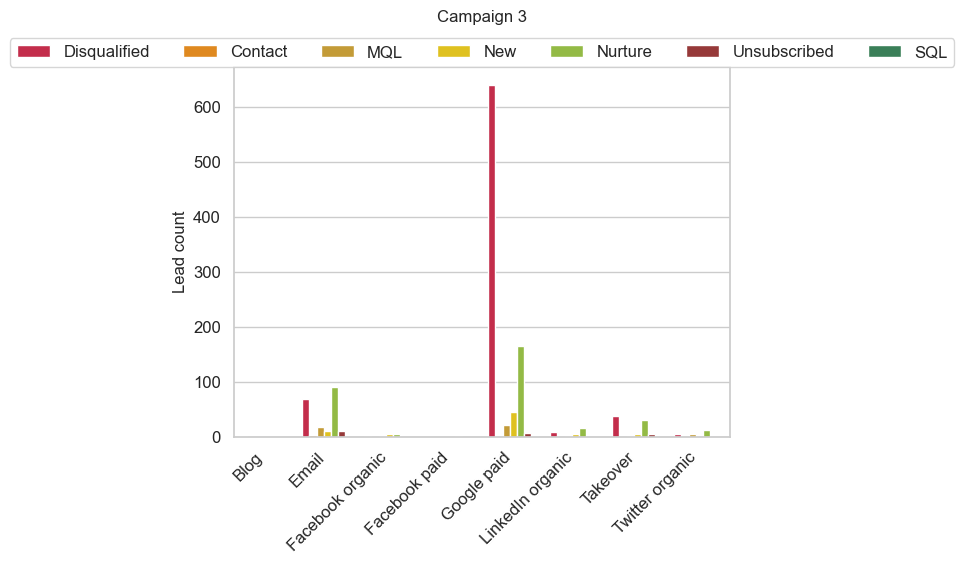

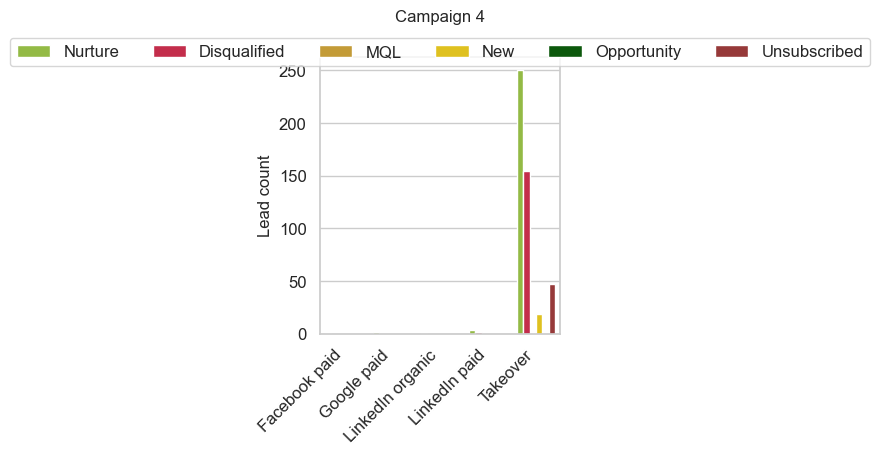

In [16]:
sns.set_theme(style="whitegrid")

data_sources=data_leads.dropna(subset=['lead_source'])  
data_sources_filtered=data_sources.drop(['campaign_joined_date','lead_job_title','lead_industry','lead_country'],axis=1)

for campaign in campaign_names:
    fig,ax=plt.subplots()
    data_sources_filtered_campaign=data_sources_filtered[data_sources_filtered['campaign_name']==campaign]
    grouped_data=data_sources_filtered_campaign.groupby(['lead_source', 'lead_status']).count().reset_index()
    
    colors=[colors_dict[k] for k in grouped_data.lead_status.unique()] 

    plot_bar=sns.barplot(data=grouped_data, x='lead_source', y='lead_hashed_id', hue='lead_status', palette=colors, ax=ax)

    ax.set_xlabel("")
    ax.set_ylabel("Lead count")

    SMALL_SIZE=12
    MEDIUM_SIZE=12
    BIGGER_SIZE=12
    
    plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=BIGGER_SIZE)   # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
    ax.yaxis.get_label().set_fontsize(BIGGER_SIZE)
    ax.xaxis.set_tick_params(labelsize=BIGGER_SIZE)
    plt.title(campaign,x=0.5, y=1.1)
    sns.move_legend(plot_bar, loc="upper center", ncol=len(colors), title=None, frameon=True, bbox_to_anchor=(0.5, 1.1))
    
    # Rotate x-axis labels
    plt.xticks(rotation=45, ha='right')
       
plt.tight_layout()
plt.show()

For completeness, leads are also classified per professional domain. Remember the domains are the result of the classifier, as the 'lead_industry' columns was not usable.

In [17]:
leads=pd.read_excel('Jobs_cleaned_and_categorized.xlsx')

#Better match between job professions and areas

joined_data=pd.merge(leads,data_leads, on='lead_hashed_id')
joined_data_clean=joined_data.drop(['Area Code','campaign_joined_date','lead_job_title_y','campaign_name_y','lead_status_y'],axis=1)

joined_data_clean.to_excel('jobs_check.xlsx')

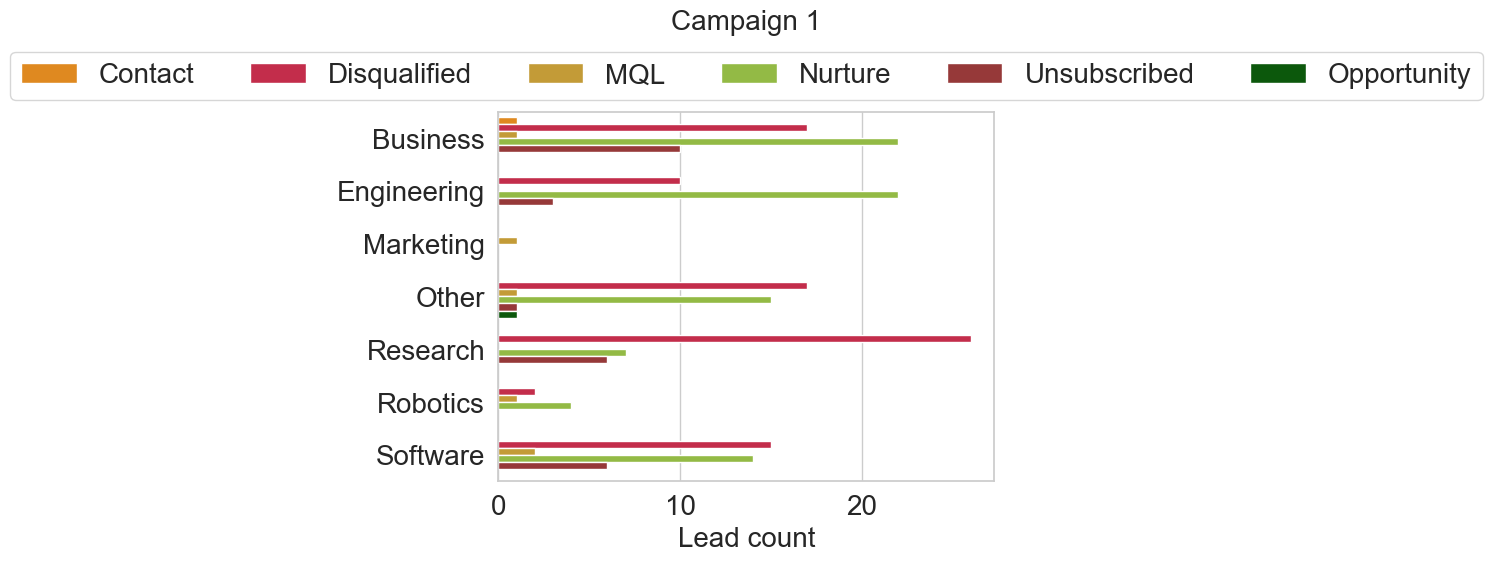

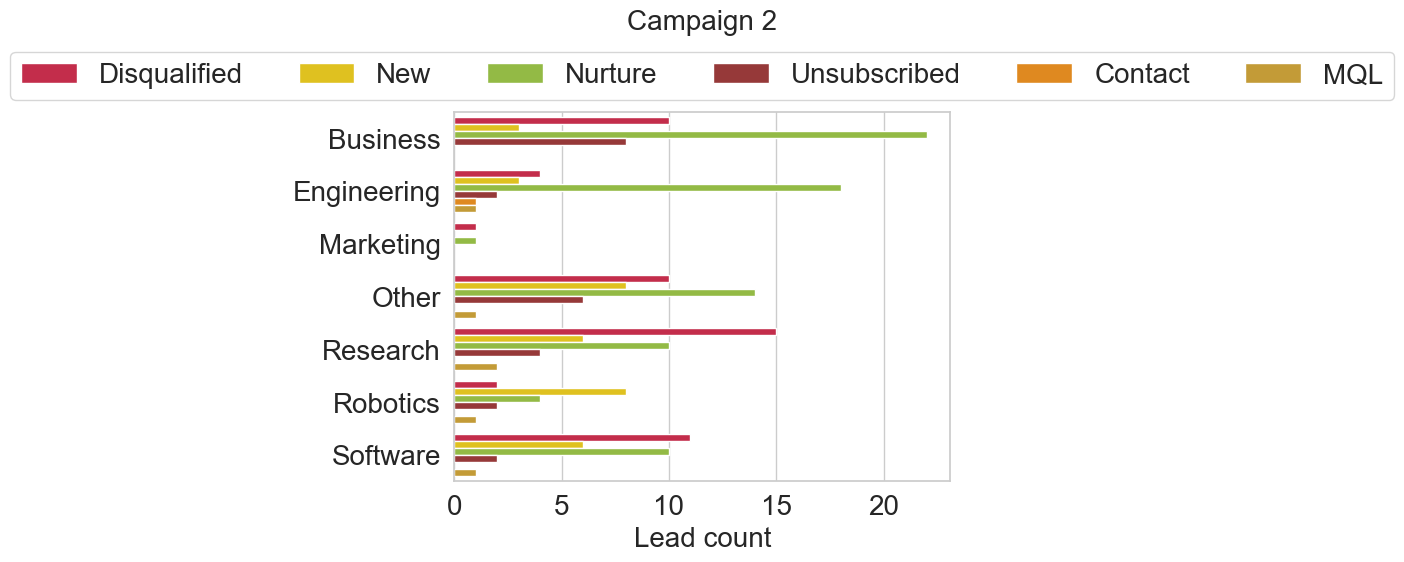

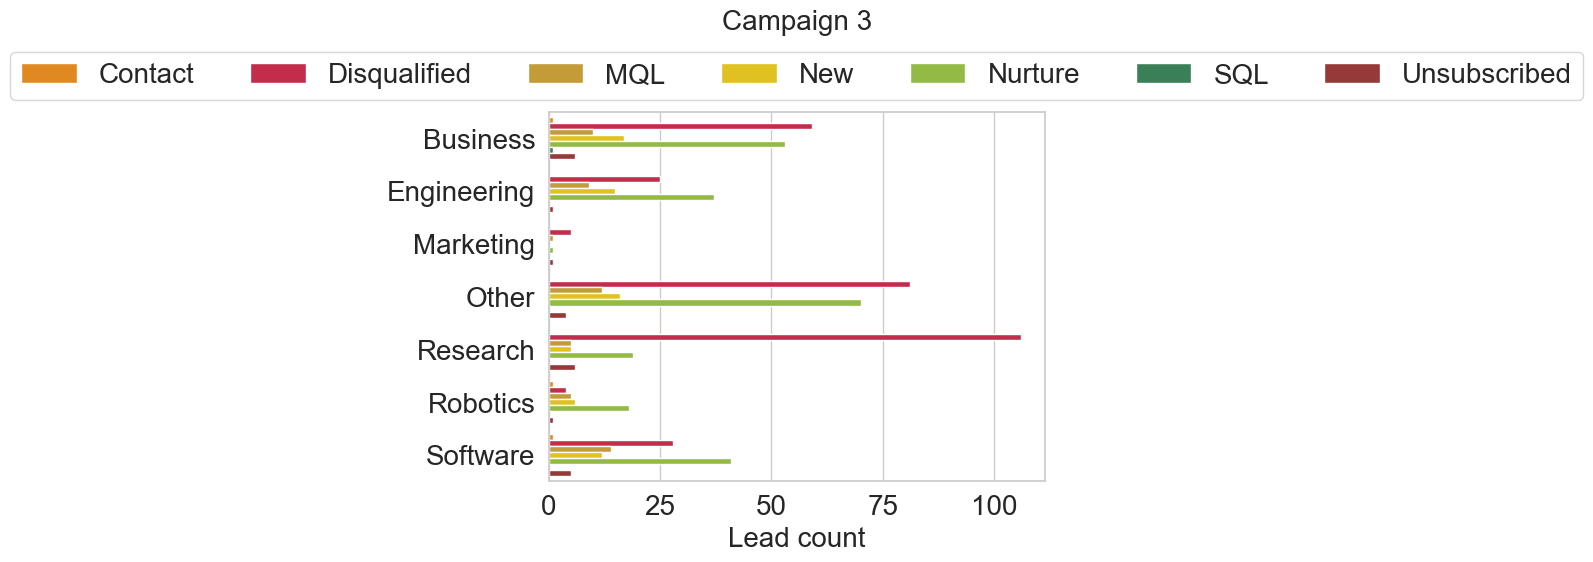

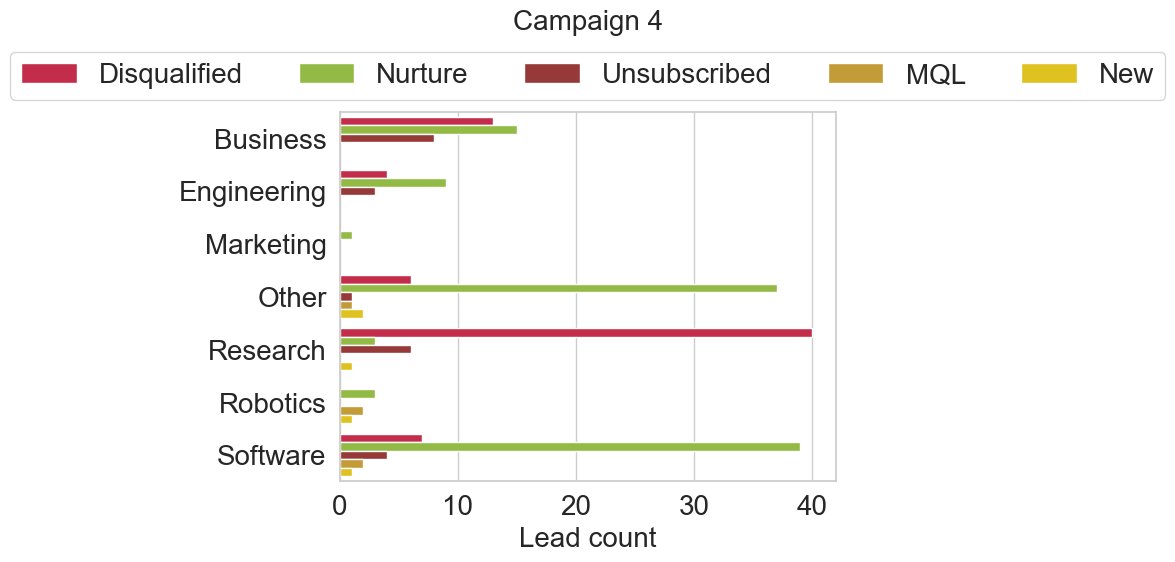

In [18]:
jobs_final=pd.read_excel('jobs_check.xlsx')

sns.set_theme(style="whitegrid")

data_sources_filtered=jobs_final

for campaign in campaign_names:
    fig,ax=plt.subplots()
    data_sources_filtered_campaign=data_sources_filtered[data_sources_filtered['campaign_name_x']==campaign]
    grouped_data=data_sources_filtered_campaign.groupby(['Area', 'lead_status_x']).count().reset_index()
    
    colors=[colors_dict[k] for k in grouped_data.lead_status_x.unique()] 

    plot_bar=sns.barplot(data=grouped_data, x='lead_hashed_id', y='Area', hue='lead_status_x', palette=colors, ax=ax)
    
    ax.set_xlabel("Lead count")
    ax.set_ylabel("")

    ticks=[ticks.get_text() for ticks in plot_bar.get_yticklabels()]
    new_labels=[] 
    for t in ticks:
        if len(t.split(' '))>1:
            if len(t.split(' '))>2:
                string_new=t.split(' ')[0]
                for s in t.split(' ')[1:-1]:
                    string_new+=' '
                    string_new+=s
                string_new+='\n'
                string_new+=t.split(' ')[-1]
                new_labels.append(string_new)
            else:
                new_labels.append(t.replace(' ', ' \n '))
        else:
            new_labels.append(t)        
    plot_bar.set_yticklabels(new_labels)


    SMALL_SIZE=20
    MEDIUM_SIZE=20
    BIGGER_SIZE=20
    
    plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
    ax.yaxis.get_label().set_fontsize(BIGGER_SIZE)
    ax.xaxis.set_tick_params(labelsize=BIGGER_SIZE)
    ax.yaxis.set_tick_params(labelsize=BIGGER_SIZE)
    ax.xaxis.get_label().set_fontsize(BIGGER_SIZE)
    plt.title(campaign,x=.5,y=1.2)

    sns.move_legend(plot_bar, loc="upper center", ncol=len(colors), title=None, frameon=True, bbox_to_anchor=(.5, 1.2))
    
plt.show()

Finally, a check on the countries targeted by the campaign. The top 5 countries in terms of quality leads are listed, and also the top 5 in terms of non-quality leads.

In [19]:
#Top 5 countries in terms of quality leads

leads_country=data_leads.drop(['lead_hashed_id','campaign_joined_date','lead_job_title','lead_industry','lead_source'], axis=1)

count_missing_country=leads_country['lead_country'].isnull().sum() #10.35% of total data is missing values

leads_country_clean=leads_country.dropna()
dict_country={}

for campaign in campaign_names:
    data_campaign=leads_country_clean[leads_country_clean['campaign_name']==campaign]
    grouped_data_campaign=data_campaign.groupby(['lead_country', 'lead_status']).count().reset_index()
    data_pivot=grouped_data_campaign.pivot(index='lead_country', columns='lead_status', values='campaign_name')
    data_pivot['Sum of quality leads']=np.zeros(len(data_pivot.index))
    quality_leads=['MQL', 'New', 'Nurture', 'Opportunity', 'SQL']
    for lead in quality_leads:
        if lead in data_pivot.columns:
            data_pivot['Sum of quality leads']+=data_pivot[lead].fillna(0)
            
    data_pivot_sorted=data_pivot.sort_values(by='Sum of quality leads', ascending=False)
    top_five=data_pivot_sorted.iloc[:5]
    dict_country[campaign]=top_five

top_five

lead_status,Disqualified,MQL,New,Nurture,Opportunity,Unsubscribed,Sum of quality leads
lead_country,,,,,,,
US,22.0,2.0,2.0,19.0,NaN,5.0,23.0
IN,4.0,NaN,NaN,19.0,NaN,2.0,19.0
BR,1.0,NaN,1.0,9.0,NaN,1.0,10.0
ID,3.0,NaN,NaN,8.0,NaN,NaN,8.0
MX,7.0,NaN,1.0,6.0,NaN,1.0,7.0


In [21]:
#Top five countries in terms of non-quality leads

leads_country=data_leads.drop(['lead_hashed_id','campaign_joined_date','lead_job_title','lead_industry','lead_source'], axis=1)

count_missing_country=leads_country['lead_country'].isnull().sum() #10.35% of total data is missing values

leads_country_clean=leads_country.dropna()
dict_country={}

for campaign in campaign_names:
    data_campaign=leads_country_clean[leads_country_clean['campaign_name']==campaign]
    grouped_data_campaign=data_campaign.groupby(['lead_country', 'lead_status']).count().reset_index()
    data_pivot=grouped_data_campaign.pivot(index='lead_country', columns='lead_status', values='campaign_name')
    data_pivot['Sum of non quality leads']=np.zeros(len(data_pivot.index))
    quality_leads=['Disqualified', 'Unsubscribed']
    for lead in quality_leads:
        if lead in data_pivot.columns:
            data_pivot['Sum of non quality leads']+=data_pivot[lead].fillna(0)
            
    data_pivot_sorted=data_pivot.sort_values(by='Sum of non quality leads', ascending=False)
    top_five=data_pivot_sorted.iloc[:5]
    dict_country[campaign]=top_five

top_five

lead_status,Disqualified,MQL,New,Nurture,Opportunity,Unsubscribed,Sum of non quality leads
lead_country,,,,,,,
US,22.0,2.0,2.0,19.0,NaN,5.0,27.0
MX,7.0,NaN,1.0,6.0,NaN,1.0,8.0
IN,4.0,NaN,NaN,19.0,NaN,2.0,6.0
AR,2.0,NaN,NaN,3.0,NaN,2.0,4.0
CA,2.0,NaN,NaN,2.0,NaN,2.0,4.0
